In [1]:
import os
import cv2
from ultralytics import YOLO
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Cài đặt môi trường và YOLO

## Cài đặt phiên bản torch và cuda phù hợp

In [15]:
# !pip uninstall -y torch torchvision torchaudio
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130
!pip install ultralytics
!pip install coloredlogs flatbuffers numpy packaging protobuf sympy
!pip install --pre --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/ort-cuda-13-nightly/pypi/simple/ onnxruntime-gpu

Looking in indexes: https://download.pytorch.org/whl/cu130
Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/ort-cuda-13-nightly/pypi/simple/


In [16]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.9.1+cu130
cuda available: True
gpu: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Demo phiên bản YOLO detection

In [17]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolo11n.pt")

# # Train the model on the COCO8 example dataset for 100 epochs
# results = model.train(data="coco8.yaml", epochs=100, imgsz=640)

# # Evaluate the model's performance on the validation set
# results = model.val()

# Run inference with the YOLO12n model on the 'bus.jpg' image
# results = model("./660x660.jpg")
results = model("D:/nguye/Downloads/Watch_face/Camera Roll/0/WIN_20251108_14_52_47_Pro.jpg")

for result in results:
    result.show() 

# # Export the model to ONNX format
# success = model.export(format="onnx")


image 1/1 D:\nguye\Downloads\Watch_face\Camera Roll\0\WIN_20251108_14_52_47_Pro.jpg: 384x640 2 persons, 1 chair, 1 couch, 2 clocks, 27.2ms
Speed: 2.6ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


## Demo phiên bản YOLO instance segmentation

In [18]:
model = YOLO("yolo11n-seg.pt")  

# Predict with the model
results = model("./660x660.jpg")  # predict on an image

# Process results list
for result in results:
    # boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk


image 1/1 d:\2025.1\AI\660x660.jpg: 640x640 2 persons, 1 bottle, 1 wine glass, 1 cup, 1 dining table, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 9.6ms postprocess per image at shape (1, 3, 640, 640)


In [35]:
model = YOLO("yolo11n-pose.pt")  

# Predict with the model
results = model("./660x660.jpg")  # predict on an image

# Process results list
for result in results:
    # boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk


image 1/1 d:\2025.1\AI\660x660.jpg: 640x640 2 persons, 9.7ms
Speed: 4.3ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


# Chuyển đổi dataset về đúng định dạng YOLO detect

## Chuyển đổi cho bài toán detect

In [19]:
import json
import shutil
from pathlib import Path

# =========================
# CONFIG
# =========================
SRC_ROOT = Path(r"D:/nguye/Downloads/Watch_face/Camera Roll/")          # <-- sửa đường dẫn tới "Camera Roll"
OUT_ROOT = Path(r"D:/2025.1/AI/datasets/watch_detect")   # <-- nơi xuất dataset YOLO

CLASSES = ["face", "knob"]
CLASS_TO_ID = {name: i for i, name in enumerate(CLASSES)}

# Split theo folder index (0..143) theo block để tránh leakage
# 144 folders -> train 0..115 (116 folders ~80.6%), val 116..129 (14 folders ~9.7%), test 130..143 (14 folders ~9.7%)
TRAIN_FOLDERS = set(range(0, 116))
VAL_FOLDERS   = set(range(116, 130))
TEST_FOLDERS  = set(range(130, 144))

# Nếu bạn muốn split khác: chỉnh các range ở trên.

IMG_EXTS = {".jpg", ".jpeg", ".png"}

# =========================
# HELPERS
# =========================
def ensure_dirs(root: Path):
    for split in ["train", "val", "test"]:
        (root / "images" / split).mkdir(parents=True, exist_ok=True)
        (root / "labels" / split).mkdir(parents=True, exist_ok=True)

def choose_split(folder_idx: int) -> str:
    if folder_idx in TRAIN_FOLDERS:
        return "train"
    if folder_idx in VAL_FOLDERS:
        return "val"
    if folder_idx in TEST_FOLDERS:
        return "test"
    # fallback: nếu folder ngoài range
    return "train"

def clamp01(x: float) -> float:
    if x < 0.0:
        return 0.0
    if x > 1.0:
        return 1.0
    return x

def rect_points_to_xyxy(points):
    """
    LabelMe rectangle: points = [[x1,y1],[x2,y2]]
    đảm bảo trả về (xmin, ymin, xmax, ymax) với đúng min/max
    """
    (x1, y1), (x2, y2) = points
    xmin = min(x1, x2)
    ymin = min(y1, y2)
    xmax = max(x1, x2)
    ymax = max(y1, y2)
    return xmin, ymin, xmax, ymax

def xyxy_to_yolo(xmin, ymin, xmax, ymax, W, H):
    """
    YOLO format: class cx cy w h (normalized)
    """
    # clamp vào biên ảnh
    xmin = max(0.0, min(float(xmin), float(W - 1)))
    xmax = max(0.0, min(float(xmax), float(W - 1)))
    ymin = max(0.0, min(float(ymin), float(H - 1)))
    ymax = max(0.0, min(float(ymax), float(H - 1)))

    bw = max(0.0, xmax - xmin)
    bh = max(0.0, ymax - ymin)
    cx = xmin + bw / 2.0
    cy = ymin + bh / 2.0

    # normalize
    cx_n = clamp01(cx / W)
    cy_n = clamp01(cy / H)
    bw_n = clamp01(bw / W)
    bh_n = clamp01(bh / H)

    return cx_n, cy_n, bw_n, bh_n

def convert_one_json_to_yolo_lines(json_path: Path):
    """
    Đọc LabelMe JSON, lấy các shape rectangle có label face/knob
    Trả về: (W, H, lines[list[str]])
    """
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    W = int(data.get("imageWidth", 0))
    H = int(data.get("imageHeight", 0))
    if W <= 0 or H <= 0:
        raise ValueError(f"Missing/invalid imageWidth/imageHeight in {json_path}")

    lines = []
    shapes = data.get("shapes", [])
    for s in shapes:
        label = s.get("label")
        if label not in CLASS_TO_ID:
            continue

        shape_type = s.get("shape_type")
        if shape_type != "rectangle":
            continue  # chỉ lấy bbox cho detect

        points = s.get("points", [])
        if not (isinstance(points, list) and len(points) == 2):
            continue

        xmin, ymin, xmax, ymax = rect_points_to_xyxy(points)
        cx, cy, bw, bh = xyxy_to_yolo(xmin, ymin, xmax, ymax, W, H)

        # Bỏ bbox quá nhỏ (tuỳ bạn; knob có thể nhỏ nên giữ ngưỡng rất thấp)
        if bw <= 0 or bh <= 0:
            continue

        cls_id = CLASS_TO_ID[label]
        lines.append(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

    return W, H, lines

def find_image_for_json(json_path: Path) -> Path | None:
    """
    Tìm ảnh cùng tên với json: WIN_... .json -> WIN_... .jpg/.png...
    """
    stem = json_path.stem
    for ext in IMG_EXTS:
        p = json_path.with_suffix(ext)
        if p.exists():
            return p
        # đôi khi ảnh khác ext nhưng vẫn cùng stem
        p2 = json_path.parent / f"{stem}{ext}"
        if p2.exists():
            return p2
    # fallback: nếu LabelMe ghi imagePath, thử tìm theo imagePath
    try:
        data = json.loads(json_path.read_text(encoding="utf-8"))
        image_path = data.get("imagePath")
        if image_path:
            p3 = json_path.parent / image_path
            if p3.exists() and p3.suffix.lower() in IMG_EXTS:
                return p3
    except Exception:
        pass
    return None

# =========================
# MAIN
# =========================
def main():
    ensure_dirs(OUT_ROOT)

    total_images = 0
    total_labels = 0
    skipped = 0
    per_split = {"train": 0, "val": 0, "test": 0}

    # Duyệt folder 0..143 (hoặc tất cả folder số)
    subfolders = []
    for p in SRC_ROOT.iterdir():
        if p.is_dir():
            try:
                idx = int(p.name)
                subfolders.append((idx, p))
            except ValueError:
                continue
    subfolders.sort(key=lambda x: x[0])

    for folder_idx, folder_path in subfolders:
        split = choose_split(folder_idx)

        # Mỗi json là 1 ảnh/label (LabelMe)
        json_files = sorted(folder_path.glob("*.json"))
        for jpath in json_files:
            img_path = find_image_for_json(jpath)
            if img_path is None:
                print(f"[SKIP] No image found for: {jpath}")
                skipped += 1
                continue

            try:
                _, _, yolo_lines = convert_one_json_to_yolo_lines(jpath)
            except Exception as e:
                print(f"[SKIP] Bad json {jpath}: {e}")
                skipped += 1
                continue

            # Tạo tên output để tránh trùng giữa các folder:
            # ví dụ: 0143__WIN_2025....jpg
            out_stem = f"{folder_idx:04d}__{img_path.stem}"
            out_img = OUT_ROOT / "images" / split / f"{out_stem}{img_path.suffix.lower()}"
            out_lbl = OUT_ROOT / "labels" / split / f"{out_stem}.txt"

            # Copy ảnh
            shutil.copy2(img_path, out_img)
            total_images += 1
            per_split[split] += 1

            # Ghi label (kể cả rỗng nếu không có face/knob, để YOLO không lỗi thiếu file)
            out_lbl.write_text("\n".join(yolo_lines) + ("\n" if yolo_lines else ""), encoding="utf-8")
            total_labels += 1

    # Tạo data.yaml
    yaml_path = OUT_ROOT / "data.yaml"
    yaml_text = f"""path: {OUT_ROOT.as_posix()}
train: images/train
val: images/val
test: images/test

names:
  0: face
  1: knob
"""
    yaml_path.write_text(yaml_text, encoding="utf-8")

    print("==== DONE ====")
    print(f"Output: {OUT_ROOT}")
    print(f"Images copied: {total_images}")
    print(f"Label files written: {total_labels}")
    print(f"Skipped: {skipped}")
    print(f"Split counts: {per_split}")
    print(f"YAML: {yaml_path}")

main()


==== DONE ====
Output: D:\2025.1\AI\datasets\watch_detect
Images copied: 1014
Label files written: 1014
Skipped: 0
Split counts: {'train': 846, 'val': 84, 'test': 84}
YAML: D:\2025.1\AI\datasets\watch_detect\data.yaml


## Demo detect dataset

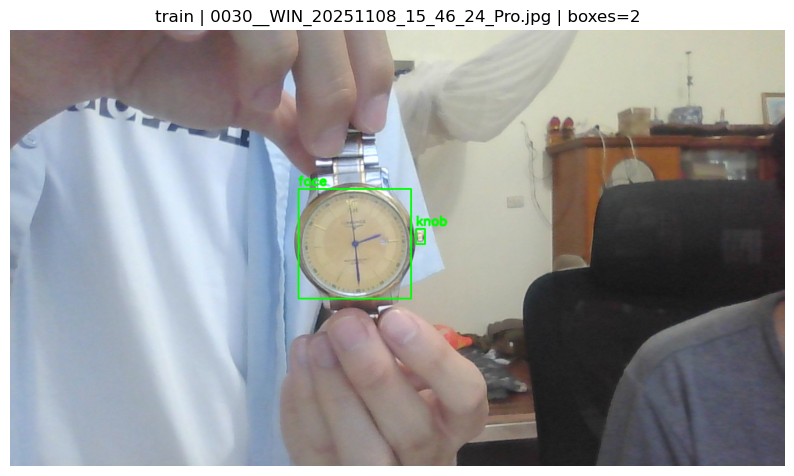

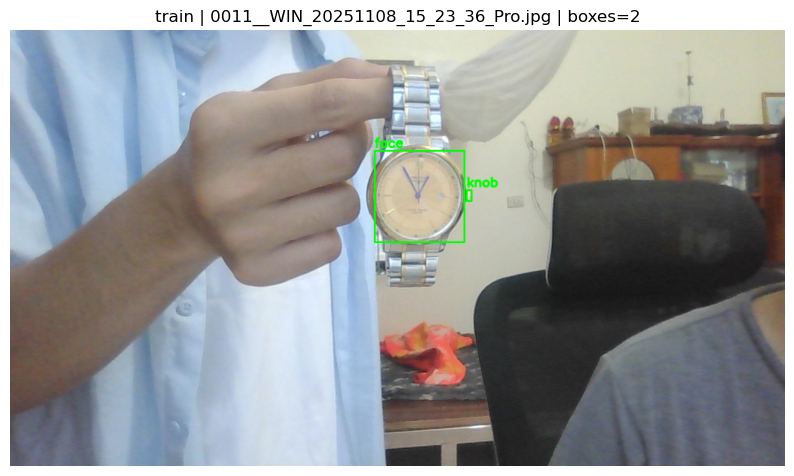

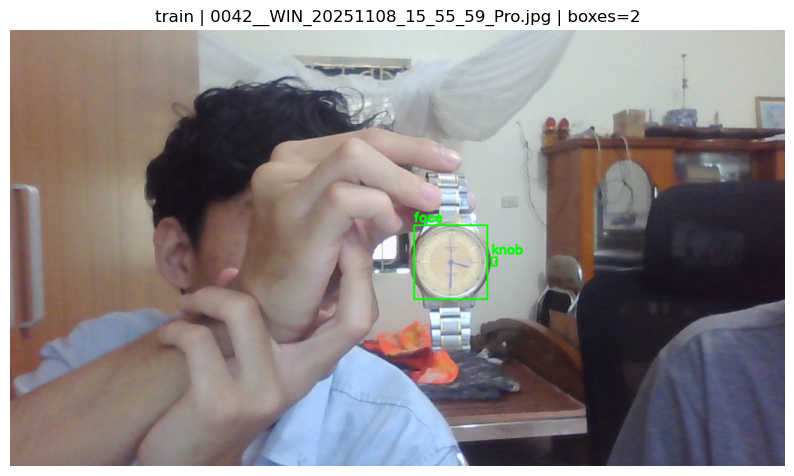

In [20]:
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
DATASET_ROOT = Path(r"D:/2025.1/AI/datasets/watch_detect")  # <-- sửa path dataset YOLO output
SPLIT = "train"  # "train" | "val" | "test"
CLASSES = ["face", "knob"]  # đúng theo data.yaml (0: face, 1: knob)

# =========================
# HELPERS
# =========================
def read_yolo_labels(label_path: Path):
    """
    Read YOLO label txt:
    class_id cx cy w h (normalized)
    Return list of (class_id, cx, cy, w, h).
    """
    if not label_path.exists():
        return []
    lines = [ln.strip() for ln in label_path.read_text(encoding="utf-8").splitlines() if ln.strip()]
    out = []
    for ln in lines:
        parts = ln.split()
        if len(parts) != 5:
            continue
        cls_id = int(float(parts[0]))
        cx, cy, w, h = map(float, parts[1:])
        out.append((cls_id, cx, cy, w, h))
    return out

def yolo_to_xyxy(cx, cy, w, h, W, H):
    """
    Convert normalized YOLO bbox to pixel xyxy (xmin, ymin, xmax, ymax)
    """
    x_c = cx * W
    y_c = cy * H
    bw = w * W
    bh = h * H
    xmin = x_c - bw / 2
    ymin = y_c - bh / 2
    xmax = x_c + bw / 2
    ymax = y_c + bh / 2
    # clip to image bounds
    xmin = max(0, min(W - 1, xmin))
    ymin = max(0, min(H - 1, ymin))
    xmax = max(0, min(W - 1, xmax))
    ymax = max(0, min(H - 1, ymax))
    return int(round(xmin)), int(round(ymin)), int(round(xmax)), int(round(ymax))

def draw_boxes_bgr(img_bgr, labels):
    """
    Draw bbox + class name on image (BGR).
    labels: list of (cls_id, cx, cy, w, h) normalized.
    """
    H, W = img_bgr.shape[:2]
    vis = img_bgr.copy()

    for (cls_id, cx, cy, w, h) in labels:
        x1, y1, x2, y2 = yolo_to_xyxy(cx, cy, w, h, W, H)
        name = CLASSES[cls_id] if 0 <= cls_id < len(CLASSES) else str(cls_id)

        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            vis,
            name,
            (x1, max(0, y1 - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )
    return vis

def show_random_samples(n=6, seed=42):
    random.seed(seed)

    img_dir = DATASET_ROOT / "images" / SPLIT
    lbl_dir = DATASET_ROOT / "labels" / SPLIT

    imgs = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        imgs.extend(img_dir.glob(ext))
    imgs = sorted(imgs)

    if not imgs:
        raise FileNotFoundError(f"No images found in: {img_dir}")

    picks = random.sample(imgs, k=min(n, len(imgs)))

    for img_path in picks:
        label_path = lbl_dir / (img_path.stem + ".txt")

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"[SKIP] Can't read image: {img_path}")
            continue

        labels = read_yolo_labels(label_path)
        vis_bgr = draw_boxes_bgr(img_bgr, labels)
        vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 6))
        plt.title(f"{SPLIT} | {img_path.name} | boxes={len(labels)}")
        plt.imshow(vis_rgb)
        plt.axis("off")
        plt.show()

# =========================
# RUN
# =========================
show_random_samples(n=3, seed=7)


## Chuyển đổi cho bài toán key/point kim đồng hồ

In [32]:
import json
import math
import shutil
from pathlib import Path

import cv2
import numpy as np

# =========================
# CONFIG (SỬA 2 DÒNG NÀY)
# =========================
SRC_ROOT = Path(r"D:/nguye/Downloads/Watch_face/Camera Roll/")          
OUT_ROOT = Path(r"D:/2025.1/AI/datasets/watch_pose")  

# Split theo folder index để tránh leakage
TRAIN_FOLDERS = set(range(0, 116))
VAL_FOLDERS   = set(range(116, 130))
TEST_FOLDERS  = set(range(130, 144))

IMG_EXTS = {".jpg", ".jpeg", ".png"}

# ROI
PAD_RATIO = 0.10     # padding quanh face bbox
OUT_SIZE = 640       # resize ROI về 640x640

# Keypoints (2 điểm): minute_tip, hour_tip
# YOLO-Pose visibility convention: 0=not labeled, 1=labeled but not visible, 2=visible
V_VISIBLE = 2
V_MISSING = 0

# =========================
# HELPERS
# =========================
def ensure_dirs(root: Path):
    for split in ["train", "val", "test"]:
        (root / "images" / split).mkdir(parents=True, exist_ok=True)
        (root / "labels" / split).mkdir(parents=True, exist_ok=True)

def choose_split(folder_idx: int) -> str:
    if folder_idx in TRAIN_FOLDERS:
        return "train"
    if folder_idx in VAL_FOLDERS:
        return "val"
    if folder_idx in TEST_FOLDERS:
        return "test"
    return "train"

def find_image_for_json(json_path: Path) -> Path | None:
    stem = json_path.stem
    for ext in IMG_EXTS:
        p = json_path.with_suffix(ext)
        if p.exists():
            return p
        p2 = json_path.parent / f"{stem}{ext}"
        if p2.exists():
            return p2
    # fallback: read imagePath
    try:
        data = json.loads(json_path.read_text(encoding="utf-8"))
        image_path = data.get("imagePath")
        if image_path:
            p3 = json_path.parent / image_path
            if p3.exists() and p3.suffix.lower() in IMG_EXTS:
                return p3
    except Exception:
        pass
    return None

def rect_points_to_xyxy(points):
    (x1, y1), (x2, y2) = points
    return min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)

def clip_box(x1, y1, x2, y2, W, H):
    x1 = max(0, min(W - 1, x1))
    y1 = max(0, min(H - 1, y1))
    x2 = max(0, min(W - 1, x2))
    y2 = max(0, min(H - 1, y2))
    return x1, y1, x2, y2

def box_center(x1, y1, x2, y2):
    return (x1 + x2) / 2.0, (y1 + y2) / 2.0

def parse_labelme(json_path: Path):
    """
    Extract:
      face_bbox (xyxy) rectangle
      knob_bbox (xyxy) rectangle
      minute_line: 2 points
      hour_line: 2 points (optional)
      imageW, imageH
    """
    data = json.loads(json_path.read_text(encoding="utf-8"))
    W = int(data["imageWidth"])
    H = int(data["imageHeight"])

    face = None
    knob = None
    minute_line = None
    hour_line = None

    for s in data.get("shapes", []):
        label = s.get("label")
        stype = s.get("shape_type")
        pts = s.get("points", [])

        if label == "face" and stype == "rectangle" and len(pts) == 2:
            face = rect_points_to_xyxy(pts)

        elif label == "knob" and stype == "rectangle" and len(pts) == 2:
            knob = rect_points_to_xyxy(pts)

        elif label == "minute_hand" and stype == "line" and len(pts) == 2:
            minute_line = pts  # [[x1,y1],[x2,y2]]

        elif label == "hour_hand" and stype == "line" and len(pts) == 2:
            hour_line = pts

    return W, H, face, knob, minute_line, hour_line

def expand_face_box(face_xyxy, W, H, pad_ratio=0.10):
    x1, y1, x2, y2 = face_xyxy
    bw = x2 - x1
    bh = y2 - y1
    pad = pad_ratio * max(bw, bh)
    x1 -= pad; y1 -= pad; x2 += pad; y2 += pad
    x1, y1, x2, y2 = clip_box(x1, y1, x2, y2, W, H)

    # make it square (better for rotation)
    cx, cy = box_center(x1, y1, x2, y2)
    side = max(x2 - x1, y2 - y1)
    x1 = cx - side / 2; x2 = cx + side / 2
    y1 = cy - side / 2; y2 = cy + side / 2
    x1, y1, x2, y2 = clip_box(x1, y1, x2, y2, W, H)
    return x1, y1, x2, y2

def pick_tip(point_a, point_b, center):
    """
    Given two points on a hand line, choose the 'tip' = point farther from center.
    """
    ax, ay = point_a
    bx, by = point_b
    cx, cy = center
    da = (ax - cx) ** 2 + (ay - cy) ** 2
    db = (bx - cx) ** 2 + (by - cy) ** 2
    return (ax, ay) if da >= db else (bx, by)

def affine_transform_points(M, pts):
    """
    Apply 2x3 affine matrix M to list of points [(x,y),...]
    """
    out = []
    for x, y in pts:
        nx = M[0, 0] * x + M[0, 1] * y + M[0, 2]
        ny = M[1, 0] * x + M[1, 1] * y + M[1, 2]
        out.append((nx, ny))
    return out

def rotate_roi_by_knob(roi_bgr, face_center_roi, knob_center_roi):
    """
    Rotate ROI so that knob is at "3 o'clock" direction (to the right).
    We rotate by -theta where theta is angle of (knob - center).
    Return rotated ROI and affine matrix mapping old ROI coords -> rotated ROI coords.
    """
    cx, cy = face_center_roi
    kx, ky = knob_center_roi
    theta = math.degrees(math.atan2(ky - cy, kx - cx))  # degrees
    angle = -theta  # rotate knob direction to 0 degrees (right)

    h, w = roi_bgr.shape[:2]
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    rotated = cv2.warpAffine(roi_bgr, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(114,114,114))
    return rotated, M

def normalize_point(pt, size):
    x, y = pt
    return x / size, y / size

# =========================
# MAIN
# =========================
def main():
    ensure_dirs(OUT_ROOT)

    # Create data.yaml for pose
    yaml_text = f"""path: {OUT_ROOT.as_posix()}
train: images/train
val: images/val
test: images/test

# 1 class for pose
names:
  0: clock

# keypoints: minute_tip, hour_tip
kpt_shape: [2, 3]
"""
    (OUT_ROOT / "data.yaml").write_text(yaml_text, encoding="utf-8")

    skipped = 0
    written = 0
    per_split = {"train": 0, "val": 0, "test": 0}

    # iterate numeric folders
    subfolders = []
    for p in SRC_ROOT.iterdir():
        if p.is_dir():
            try:
                idx = int(p.name)
                subfolders.append((idx, p))
            except ValueError:
                pass
    subfolders.sort(key=lambda x: x[0])

    for folder_idx, folder_path in subfolders:
        split = choose_split(folder_idx)

        for json_path in sorted(folder_path.glob("*.json")):
            img_path = find_image_for_json(json_path)
            if img_path is None:
                print(f"[SKIP] No image for {json_path}")
                skipped += 1
                continue

            try:
                W, H, face, knob, minute_line, hour_line = parse_labelme(json_path)
            except Exception as e:
                print(f"[SKIP] Bad json {json_path}: {e}")
                skipped += 1
                continue

            # Require face + knob + minute_hand (minute is essential for minutes)
            if face is None or knob is None or minute_line is None:
                print(f"[SKIP] Missing face/knob/minute in {json_path.name}")
                skipped += 1
                continue

            img = cv2.imread(str(img_path))
            if img is None:
                print(f"[SKIP] Cannot read image {img_path}")
                skipped += 1
                continue

            # Expand square ROI around face
            fx1, fy1, fx2, fy2 = expand_face_box(face, W, H, PAD_RATIO)
            fx1i, fy1i, fx2i, fy2i = map(int, map(round, [fx1, fy1, fx2, fy2]))
            roi = img[fy1i:fy2i, fx1i:fx2i].copy()
            if roi.size == 0:
                print(f"[SKIP] Empty ROI {img_path}")
                skipped += 1
                continue

            # Centers in original image
            fcx, fcy = box_center(*face)
            kx1, ky1, kx2, ky2 = knob
            kcx, kcy = box_center(kx1, ky1, kx2, ky2)

            # Convert centers to ROI coordinates
            fcx_roi = fcx - fx1i
            fcy_roi = fcy - fy1i
            kcx_roi = kcx - fx1i
            kcy_roi = kcy - fy1i

            # Convert hand tip points to ROI
            minute_tip = pick_tip(minute_line[0], minute_line[1], (fcx, fcy))
            minute_tip_roi = (minute_tip[0] - fx1i, minute_tip[1] - fy1i)

            hour_tip_roi = None
            if hour_line is not None:
                hour_tip = pick_tip(hour_line[0], hour_line[1], (fcx, fcy))
                hour_tip_roi = (hour_tip[0] - fx1i, hour_tip[1] - fy1i)

            # Rotate ROI so knob at right
            roi_rot, M = rotate_roi_by_knob(roi, (fcx_roi, fcy_roi), (kcx_roi, kcy_roi))

            # Transform keypoints with same affine
            pts = [minute_tip_roi]
            if hour_tip_roi is not None:
                pts.append(hour_tip_roi)

            pts_rot = affine_transform_points(M, pts)
            minute_tip_rot = pts_rot[0]
            hour_tip_rot = pts_rot[1] if hour_tip_roi is not None else None

            # Resize to OUT_SIZE x OUT_SIZE
            h0, w0 = roi_rot.shape[:2]
            roi_out = cv2.resize(roi_rot, (OUT_SIZE, OUT_SIZE), interpolation=cv2.INTER_LINEAR)

            # Scale keypoints accordingly
            sx = OUT_SIZE / w0
            sy = OUT_SIZE / h0
            minute_out = (minute_tip_rot[0] * sx, minute_tip_rot[1] * sy)
            if hour_tip_rot is not None:
                hour_out = (hour_tip_rot[0] * sx, hour_tip_rot[1] * sy)
            else:
                hour_out = (0.0, 0.0)

            # Normalize to [0,1] and clip
            mx, my = minute_out[0] / OUT_SIZE, minute_out[1] / OUT_SIZE
            mx = float(np.clip(mx, 0.0, 1.0)); my = float(np.clip(my, 0.0, 1.0))

            hx, hy = hour_out[0] / OUT_SIZE, hour_out[1] / OUT_SIZE
            hx = float(np.clip(hx, 0.0, 1.0)); hy = float(np.clip(hy, 0.0, 1.0))

            mv = V_VISIBLE
            hv = V_VISIBLE if hour_tip_rot is not None else V_MISSING

            # Output filenames (avoid collisions)
            out_stem = f"{folder_idx:04d}__{img_path.stem}"
            out_img = OUT_ROOT / "images" / split / f"{out_stem}.jpg"
            out_lbl = OUT_ROOT / "labels" / split / f"{out_stem}.txt"

            # Save image
            cv2.imwrite(str(out_img), roi_out)

            # YOLO-Pose label: class + bbox(full image) + 2 keypoints (x y v)*2
            # bbox = 0.5 0.5 1 1 (normalized)
            label_line = f"0 0.5 0.5 1.0 1.0 {mx:.6f} {my:.6f} {mv} {hx:.6f} {hy:.6f} {hv}\n"
            out_lbl.write_text(label_line, encoding="utf-8")

            written += 1
            per_split[split] += 1

    print("==== DONE ====")
    print(f"Output: {OUT_ROOT}")
    print(f"Written: {written}")
    print(f"Skipped: {skipped}")
    print(f"Split counts: {per_split}")
    print(f"data.yaml: {OUT_ROOT / 'data.yaml'}")

if __name__ == "__main__":
    main()


[SKIP] Missing face/knob/minute in WIN_20251108_15_07_42_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_08_42_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_10_12_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_10_17_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_10_54_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_11_50_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_26_38_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_26_49_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_52_56_Pro.json
==== DONE ====
Output: D:\2025.1\AI\datasets\watch_pose
Written: 1005
Skipped: 9
Split counts: {'train': 837, 'val': 84, 'test': 84}
data.yaml: D:\2025.1\AI\datasets\watch_pose\data.yaml


## Demo pose dataset

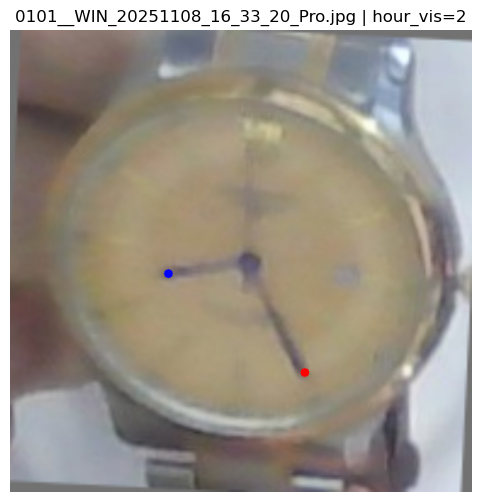

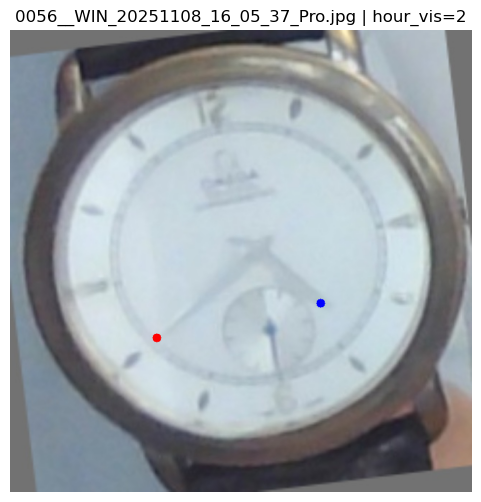

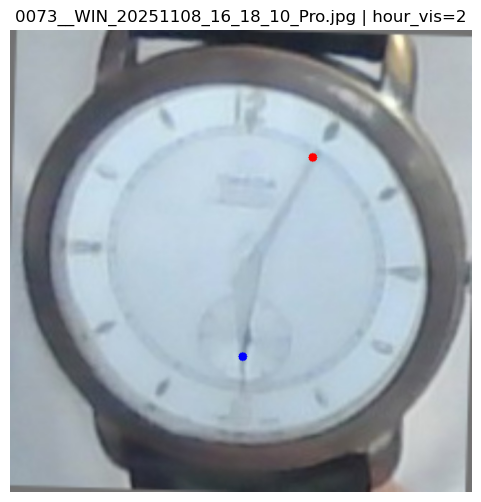

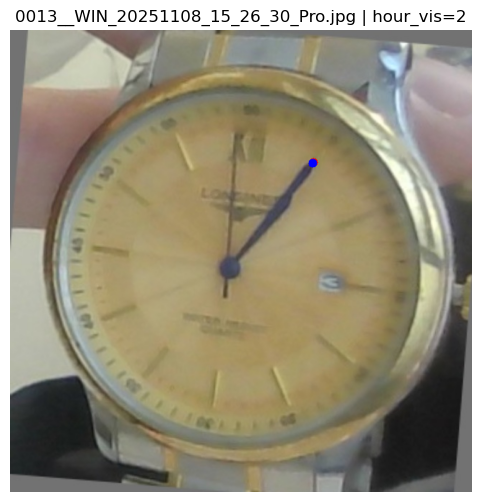

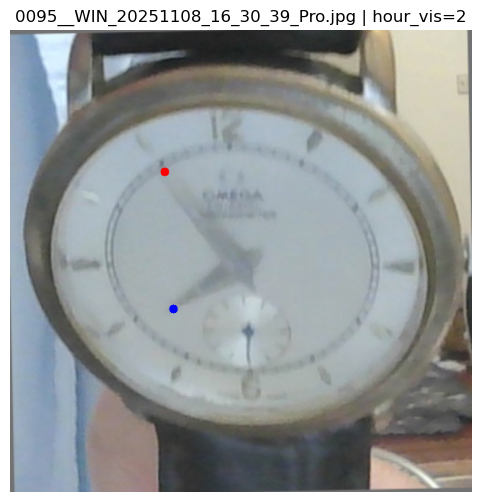

In [34]:
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

ROOT = Path(r"D:/2025.1/AI/datasets/watch_pose")
SPLIT = "train"
CLASSES = ["clock"]

def read_pose_label(txt_path: Path):
    s = txt_path.read_text(encoding="utf-8").strip().split()
    # class cx cy w h  mx my mv  hx hy hv
    mx, my, mv = float(s[5]), float(s[6]), int(float(s[7]))
    hx, hy, hv = float(s[8]), float(s[9]), int(float(s[10]))
    return (mx, my, mv), (hx, hy, hv)

img_dir = ROOT / "images" / SPLIT
lbl_dir = ROOT / "labels" / SPLIT
imgs = sorted(img_dir.glob("*.jpg"))

def show_random_samples(n=8):
    for img_path in random.sample(imgs, k=min(n, len(imgs))):
        lbl_path = lbl_dir / (img_path.stem + ".txt")
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[:2]
        (mx, my, mv), (hx, hy, hv) = read_pose_label(lbl_path)

        # draw minute tip (red), hour tip (blue if exists)
        if mv != 0:
            cv2.circle(img_rgb, (int(mx * W), int(my * H)), 6, (255, 0, 0), -1)
        if hv != 0:
            cv2.circle(img_rgb, (int(hx * W), int(hy * H)), 6, (0, 0, 255), -1)

        plt.figure(figsize=(6,6))
        plt.title(f"{img_path.name} | hour_vis={hv}")
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()

show_random_samples(n=5)


# Train mô hình phát hiện đồng hồ

## Làm sạch thư mục run để chạy lại

In [28]:
import shutil
from pathlib import Path

PROJECT = "runs_watch_face"
NAME = "yolo11n_detect_face_knob"
run_dir = Path(PROJECT) / NAME
if run_dir.exists():
    shutil.rmtree(run_dir)  # xóa sạch lần chạy trước

## Huấn luyện

New https://pypi.org/project/ultralytics/8.3.252 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.250  Python-3.13.5 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/2025.1/AI/datasets/watch_detect/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=

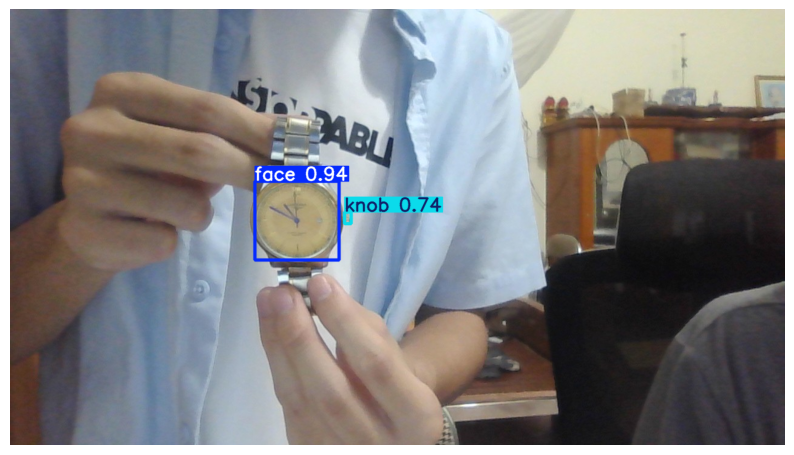

In [29]:
from ultralytics import YOLO


DATA_YAML = r"D:/2025.1/AI/datasets/watch_detect/data.yaml"   
TEST_IMAGE = r"D:/2025.1/AI/datasets/watch_detect/images/test/0130__WIN_20251108_16_46_51_Pro.jpg"

# =========================
# 1) Load pretrained detection model
# =========================
model = YOLO("yolo11n.pt")

# =========================
# 2) Train
# =========================
results = model.train(
    data=DATA_YAML,
    epochs=50,
    imgsz=640,
    batch=16,        # nếu VRAM ít thì giảm xuống 8/4
    device=0,        # nếu chưa có CUDA thì đổi thành "cpu"
    workers=8,       # quan trọng để tránh WinError 5 trên Windows
    project=PROJECT,
    name=NAME,
    pretrained=True,
    cache=True,     # nếu ổ cứng nhanh + RAM đủ, có thể để True
    verbose=True,
    exist_ok=True
)

# =========================
# 3) Validate
# =========================
val_results = model.val(
    data=DATA_YAML,
    imgsz=640,
    device=0,
    workers=0
)

# =========================
# 4) Inference test 1 ảnh
# =========================
pred = model.predict(
    source=TEST_IMAGE,
    imgsz=640,
    conf=0.25,
    iou=0.7,
    device=0,
    workers=0,
    save=True,      # lưu ảnh kết quả ra runs/
    show=False,     # tránh treo do GUI
    verbose=True
)

# Nếu bạn muốn xem ngay trong notebook bằng matplotlib (không dùng result.show()):
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(TEST_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# pred[0].plot() trả ảnh đã vẽ bbox (BGR)
vis_bgr = pred[0].plot()
vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(vis_rgb)
plt.axis("off")
plt.show()


## Xuất model onnx

In [30]:
# =========================
# 5) Export ONNX (optional)
# =========================
model.export(format="onnx")

Ultralytics 8.3.250  Python-3.13.5 torch-2.9.1+cu130 CPU (12th Gen Intel Core i7-12700H)

PyTorch: starting from 'D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.2 MB)

ONNX: starting export with onnx 1.20.1 opset 22...


c:\Users\nguye\anaconda3\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success  1.2s, saved as 'D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.onnx' (10.1 MB)

Export complete (1.4s)
Results saved to D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights
Predict:         yolo predict task=detect model=D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.onnx imgsz=640 data=D:/2025.1/AI/datasets/watch_detect/data.yaml  
Visualize:       https://netron.app


'D:\\2025.1\\AI\\runs_watch_face\\yolo11n_detect_face_knob\\weights\\best.onnx'

## Demo onnx model

In [31]:
# Đường dẫn ONNX đã export
onnx_path = r"D:/2025.1/AI/runs_watch_face/yolo11n_detect_face_knob/weights/best.onnx"

model = YOLO(onnx_path)

# Live webcam (source=0). Nhấn 'q' để thoát.
model.predict(
    source=0,
    imgsz=640,
    conf=0.25,
    iou=0.7,
    show=True,      # mở cửa sổ xem live
    device="gpu",   # ONNX thường chạy CPU trừ khi bạn cài onnxruntime-gpu
    verbose=False
)

WARNING Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading D:/2025.1/AI/runs_watch_face/yolo11n_detect_face_knob/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.24.0.dev20260109001 with CUDAExecutionProvider
1/1: 0... Success  (inf frames of shape 640x480 at 30.00 FPS)

WARNING 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

WARNING Waiting for stream 0
WARNING Waiting for 

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'face', 1: 'knob'}
 obb: None
 orig_img: array([[[233, 237, 236],
         [233, 237, 236],
         [232, 236, 235],
         ...,
         [232, 236, 235],
         [233, 237, 236],
         [233, 237, 236]],
 
        [[233, 237, 236],
         [233, 237, 236],
         [232, 236, 235],
         ...,
         [232, 236, 235],
         [233, 237, 236],
         [233, 237, 236]],
 
        [[232, 236, 235],
         [232, 236, 235],
         [233, 237, 236],
         ...,
         [233, 237, 236],
         [232, 236, 235],
         [232, 236, 235]],
 
        ...,
 
        [[250, 218, 222],
         [248, 218, 221],
         [248, 218, 220],
         ...,
         [232, 236, 235],
         [232, 236, 235],
         [232, 236, 235]],
 
        [[249, 217, 223],
         [249, 217, 222],
         [247, 216, 221],
         ...,
         

# Train mô hình nhận diện kim

# Làm sạch thư mục run để chạy lại

In [2]:
import shutil
from pathlib import Path

PROJECT = "runs_watch_pose"
NAME = "pose_minute_hour_tip"
run_dir = Path(PROJECT) / NAME
if run_dir.exists():
    shutil.rmtree(run_dir)  # xóa sạch lần chạy trước

## Huấn luyện

In [3]:
DATA_YAML = r"D:/2025.1/AI/datasets/watch_pose/data.yaml"

model = YOLO("yolo11n-pose.pt")

results = model.train(
    data=DATA_YAML,
    epochs=50,
    imgsz=640,
    batch=16,        
    device=0,        
    workers=8,       
    project=PROJECT,
    name=NAME,
    exist_ok=True,   
    verbose=True
)

# Validate
val = model.val(data=DATA_YAML, imgsz=640, device=0, workers=0)
print(val)


New https://pypi.org/project/ultralytics/8.3.252 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.250  Python-3.13.5 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/2025.1/AI/datasets/watch_pose/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

## Demo trên tập dữ liệu

In [ ]:
import math
import numpy as np
from ultralytics import YOLO

POSE_MODEL = YOLO(r"D:/2025.1/AI/runs_watch_pose/pose_minute_hour_tip/weights/best.pt")

def angle_clockwise_from_12(cx, cy, x, y):
    """
    Trả về góc phi (độ) trong [0,360), với:
    - 0 độ ở 12 giờ (hướng lên)
    - tăng theo chiều kim đồng hồ
    """
    # atan2 trả về góc so với +x (hướng phải), CCW
    alpha = math.degrees(math.atan2(y - cy, x - cx))  # [-180,180], 0 ở hướng phải
    # đổi sang 0 ở 12 giờ, CW:
    phi = (90 - alpha) % 360
    return phi

def circular_diff_deg(a, b):
    """khoảng cách góc nhỏ nhất giữa a và b (độ)"""
    d = (a - b + 180) % 360 - 180
    return abs(d)

def decode_time_from_tips(min_tip, hour_tip=None):
    """
    min_tip: (x,y) pixel in ROI
    hour_tip: (x,y) pixel or None
    ROI center lấy là trung tâm ảnh (vì bbox=full image trong dataset pose)
    """
    # center (có thể dùng (W/2,H/2) vì ROI đã crop quanh mặt đồng hồ)
    # nếu bạn muốn chính xác hơn nữa: lưu center từ face bbox trước đó
    # nhưng thường W/2,H/2 là ổn khi ROI là mặt đồng hồ.
    return

def predict_time_from_roi_image(img_path, conf=0.25):
    """
    img_path: ảnh ROI đã chuẩn hóa (từ dataset pose hoặc pipeline detect->crop->rotate)
    """
    pred = POSE_MODEL.predict(source=img_path, imgsz=640, conf=conf, device=0, workers=0, verbose=False)
    r = pred[0]

    if r.keypoints is None or len(r.keypoints) == 0:
        return None

    # Lấy detection có confidence cao nhất
    # r.boxes.conf: tensor [n]
    idx = int(r.boxes.conf.argmax().item()) if r.boxes is not None and len(r.boxes) else 0

    # keypoints shape: [n, k, 3] với (x,y,conf)
    kpts = r.keypoints.data[idx].cpu().numpy()  # [2,3] => minute_tip, hour_tip

    # minute (kpt 0), hour (kpt 1)
    mx, my, mconf = kpts[0]
    hx, hy, hconf = kpts[1]

    # ảnh
    import cv2
    img = cv2.imread(str(img_path))
    H, W = img.shape[:2]
    cx, cy = W / 2.0, H / 2.0

    # minute angle -> minute
    phi_m = angle_clockwise_from_12(cx, cy, mx, my)
    minute = int(round(phi_m / 6.0)) % 60  # 6 độ mỗi phút

    # hour
    hour = None
    hour_ambiguous = False

    # Ngưỡng để xem hour tip có “tồn tại” (vì label missing thì model thường cho conf rất thấp)
    if hconf >= 0.2:  # bạn có thể tune 0.15~0.3
        phi_h = angle_clockwise_from_12(cx, cy, hx, hy)

        # Chọn hour sao cho góc kim giờ gần 30*hour + 0.5*minute nhất
        best_h = 0
        best_err = 1e9
        for h in range(12):
            expected = (30.0 * h + 0.5 * minute) % 360
            err = circular_diff_deg(phi_h, expected)
            if err < best_err:
                best_err = err
                best_h = h
        hour = best_h

        # Nếu minute gần 0 và hour_tip cũng gần minute_tip thì vẫn có thể ambiguous
        if minute in (0, 59, 1) and best_err < 5:
            # 0:00/12:00 bản chất giống nhau nếu bạn không phân biệt AM/PM
            hour_ambiguous = True

    else:
        # hour_tip không đáng tin / không thấy
        # Quy tắc tối thiểu: nếu minute ~ 0 thì hour bị mơ hồ
        if minute in (0, 59, 1):
            hour = 0  # hoặc 12 tùy quy ước bạn chọn
            hour_ambiguous = True
        else:
            # Không đủ thông tin từ 1 ảnh để suy hour chắc chắn
            hour = None
            hour_ambiguous = True

    return {
        "minute": minute,
        "hour": hour,
        "minute_conf": float(mconf),
        "hour_conf": float(hconf),
        "hour_ambiguous": hour_ambiguous
    }

# Demo: chạy trên 1 ảnh ROI trong dataset pose
# demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/train/0003__WIN_20251108_15_09_57_Pro.jpg" # 1h15' thành 4h16'
# demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/train/0002__WIN_20251108_15_07_44_Pro.jpg" # 1h10' thành 4h26'
# demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/val/0122__WIN_20251108_16_43_30_Pro.jpg" # 10h10' thành 5h23'
demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/test/0130__WIN_20251108_16_46_48_Pro.jpg" # 10h50' thành 8h42'
print(predict_time_from_roi_image(demo_img))


{'minute': 42, 'hour': 8, 'minute_conf': 0.9856701493263245, 'hour_conf': 0.9501938819885254, 'hour_ambiguous': False}


In [6]:
import math
import cv2
import numpy as np
from ultralytics import YOLO

POSE_MODEL = YOLO(r"D:/2025.1/AI/runs_watch_pose/pose_minute_hour_tip/weights/best.pt")

def angle_clockwise_from_12(cx, cy, x, y, offset_deg=0.0):
    """
    0° = 12h (up), increase clockwise.
    offset_deg: dùng khi ROI bị xoay (nếu cần).
    """
    alpha = math.degrees(math.atan2(y - cy, x - cx))  # 0° at +x, CCW
    phi = (90 - alpha - offset_deg) % 360
    return phi

def circular_diff_deg(a, b):
    d = (a - b + 180) % 360 - 180
    return abs(d)

def radius(cx, cy, x, y):
    return math.hypot(x - cx, y - cy)

def predict_time_from_roi_image(img_path, conf=0.25, kp_conf_th=0.2, min_radius_ratio=0.20, offset_deg=0.0):
    """
    min_radius_ratio: tip phải cách tâm ít nhất min_radius_ratio * min(W,H)/2
    offset_deg: nếu ROI bị xoay so với chuẩn 12h-up, truyền offset (độ)
    """
    pred = POSE_MODEL.predict(source=img_path, imgsz=640, conf=conf, device=0, workers=0, verbose=False)
    r = pred[0]
    if r.keypoints is None or len(r.keypoints) == 0:
        return None

    idx = int(r.boxes.conf.argmax().item()) if r.boxes is not None and len(r.boxes) else 0
    kpts = r.keypoints.data[idx].cpu().numpy()  # [2,3]

    mx, my, mconf = kpts[0]
    hx, hy, hconf = kpts[1]

    img = cv2.imread(str(img_path))
    H, W = img.shape[:2]
    cx, cy = W / 2.0, H / 2.0

    # --- sanity: tip distance ---
    rmin = min(W, H) / 2.0
    min_r_th = min_radius_ratio * rmin

    # minute must exist
    if mconf < kp_conf_th or radius(cx, cy, mx, my) < min_r_th:
        return None  # minute không tin được -> bỏ

    phi_m = angle_clockwise_from_12(cx, cy, mx, my, offset_deg=offset_deg)
    minute = int(round(phi_m / 6.0)) % 60

    # hour decoding
    hour = None
    ambiguous = False
    hour_err = None

    hour_ok = (hconf >= kp_conf_th) and (radius(cx, cy, hx, hy) >= 0.12 * rmin)  # hour thường ngắn hơn nên ngưỡng nhỏ hơn
    if hour_ok:
        phi_h = angle_clockwise_from_12(cx, cy, hx, hy, offset_deg=offset_deg)

        best_h, best_err = 0, 1e9
        for h in range(12):
            expected = (30.0 * h + 0.5 * minute) % 360
            err = circular_diff_deg(phi_h, expected)
            if err < best_err:
                best_err = err
                best_h = h

        hour = best_h
        hour_err = float(best_err)

        # nếu sai khác lớn, coi như hour không đáng tin
        if best_err > 12:  # 12° ~ 24 phút trên kim giờ -> khá lớn
            ambiguous = True

        # case minute gần 0: hour có thể trùng minute (mơ hồ)
        if minute in (0, 59, 1) and best_err < 6:
            ambiguous = True
    else:
        # hour missing
        if minute in (0, 59, 1):
            hour = 0
            ambiguous = True
        else:
            hour = None
            ambiguous = True

    return {
        "minute": minute,
        "hour": hour,
        "minute_conf": float(mconf),
        "hour_conf": float(hconf),
        "hour_err_deg": hour_err,
        "ambiguous": ambiguous
    }


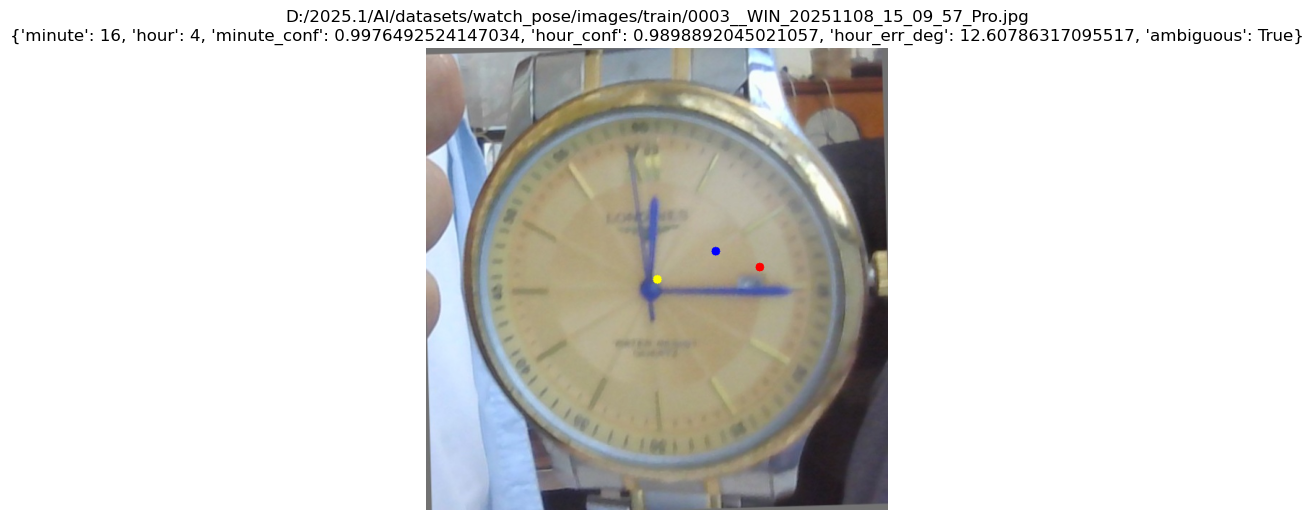

In [11]:
import cv2
import matplotlib.pyplot as plt
import math

def draw_debug(img_path):
    out = predict_time_from_roi_image(img_path)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]
    cx, cy = int(W/2), int(H/2)

    # dự đoán raw kpts
    pred = POSE_MODEL.predict(source=img_path, imgsz=640, conf=0.25, device=0, workers=0, verbose=False)[0]
    idx = int(pred.boxes.conf.argmax().item()) if pred.boxes is not None and len(pred.boxes) else 0
    kpts = pred.keypoints.data[idx].cpu().numpy()
    mx, my, mconf = kpts[0]
    hx, hy, hconf = kpts[1]

    # draw center + points
    cv2.circle(img_rgb, (cx, cy), 6, (255, 255, 0), -1)           # center
    cv2.circle(img_rgb, (int(mx), int(my)), 6, (255, 0, 0), -1)   # minute (red)
    cv2.circle(img_rgb, (int(hx), int(hy)), 6, (0, 0, 255), -1)   # hour (blue)

    plt.figure(figsize=(6,6))
    plt.title(f"{img_path}\n{out}")
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# Demo: chạy trên 1 ảnh ROI trong dataset pose
demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/train/0003__WIN_20251108_15_09_57_Pro.jpg" # 1h15' thành 4h16'
# demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/train/0002__WIN_20251108_15_07_44_Pro.jpg" # 1h10' thành 4h26'
# demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/val/0122__WIN_20251108_16_43_30_Pro.jpg" # 10h10' thành 5h23'
# demo_img = r"D:/2025.1/AI/datasets/watch_pose/images/test/0130__WIN_20251108_16_46_48_Pro.jpg" # 10h50' thành 8h42'
draw_debug(demo_img)

## Xuất model onnx